# Gideon Mooijen, 10686290
### Masterthesis, 16-08-2020

### Import libraries, gather datasources

In [5]:
print('Importing libraries...')
import pandas as pd
import os 
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import networkx as nx

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.patheffects as path_effects
from mpl_toolkits.mplot3d.art3d import Line3DCollection

homedir = os.getcwd()

# convert postalcode to provincie
print('Convert postal code to county...')
geo_attr = pd.read_csv(os.path.join(homedir,'map','post_to_geo_attr.csv'))
geo_attr = geo_attr.drop(['Unnamed: 0','LAT','LONG'],axis=1)
postal_to_provence = geo_attr[['POSTAL_NUM','NAME_1']].copy().rename(columns={'NAME_1':'PROVENCE'})

# add postal code to BEID
print('Add postalcode to BEID...')
beid_to_postal = pd.read_excel(os.path.join(homedir,'map','postal.xlsx'))
beid_to_postal = beid_to_postal.rename(columns={'BeIdentificatie':'BEID','PostcodeNumeriek':'POSTAL_NUM','PostcodeLetters':'POSTAL_LET'})
beid_to_postal = beid_to_postal[['BEID','POSTAL_NUM','POSTAL_LET']].copy()

# merge BEID/postal/provincie with all other metadata
print('Merge all metadata...')
all_meta = pd.merge(beid_to_postal,postal_to_provence,how='left',on='POSTAL_NUM')

# filter: [large_beids] contains beids of companies > 5 employees
# note: datasource (2013) does not match other data (2018) and can not be used
print('Filter synthetic data...')
comp_size = pd.read_excel(os.path.join(homedir,'data','E_prodcom','comp_size.xlsx'))
large_comps = comp_size[comp_size['WPActueel']>19]
large_beids = large_comps['BeIdentificatie'].values
all_comps = comp_size['BeIdentificatie'].values

# load commodity code / commodity name into dataframe commodities
print('Loading all commodities...')
commodities = pd.read_csv(os.path.join(homedir,'data','E_prodcom','commoditygroup.csv'),sep=';', header=0, encoding='latin8')

# load regkol code / regkol name into dataframe commodities
print('Loading all nace codes...')
regkols = pd.read_csv(os.path.join(homedir,'data','regkols.txt'),sep=',', header=0, encoding='latin8')

Importing libraries...
Convert postal code to county...
Add postalcode to BEID...
Merge all metadata...
Filter synthetic data...
Loading all commodities...
Loading all nace codes...


#### Transform commodity and regkol codes

In [6]:
# if commodity name: return commodity code
# if commodity code: return commodity name
def get_commodity(name_or_code):
    if isinstance(name_or_code,int): 
        return commodities.loc[commodities['code'] == name_or_code]['name'].values[0]
    return commodities.loc[commodities['name'] == name_or_code]['code'].values[0]

# if regkol name: return regkol code
# if regkol code: return regkol name
def get_regkol(name_or_code):
    if isinstance(name_or_code,int): 
        return regkols.loc[regkols['rk_code'] == name_or_code]['rk_info'].values[0]
    return regkols.loc[regkols['rk_info'] == name_or_code]['rk_code'].values[0]


# filter industrial commodities
# relevant_com1 = commodities[commodities['code'] > lb1-1]
# relevant_com1 = relevant_com1[relevant_com1['code']< ub1 +1]
# relevant_com2 = commodities[commodities['code'] > lb2-1]
# relevant_com2 = relevant_com2[relevant_com2['code']< ub2 +1]
# relevant_commodities = pd.concat([part1,part2])

#### Retrieve producers/suppliers
#### Obtain which industries produce or consume a commodity

In [7]:
# if supply = 'supply': return producers of commodity commodity
# if supply = 'use':    return consucers of commodity commodity
def get_companies(supply,commodity):
    base_path = os.path.join(homedir,'data','E_prodcom')
    commodity = str(commodity) + '.csv'
    path = os.path.join(base_path,supply,commodity)
    companies = pd.read_csv(path,sep=';').rename(columns={'id':'BEID'})
    if companies['volume'].dtype == object:
        companies['volume'] = companies['volume'].str.split(',').str[0]
    companies['volume'] = companies['volume'].astype('int32')
    companies['rel_volume'] = companies['volume']/companies['volume'].sum()*100
    return companies

# if supply = 'supply': return distribution of nace of producers
# if supply = 'use':    return distribution of nace of consumers
def get_nace_distribution(supply,commodity):
    if supply == 'both':
        iterations = ['supply','use']
    else:
        iterations = [supply]
    for it in iterations:
        print(it,'\t',commodity)
        nodes = get_companies(it,commodity)
        for niche in nodes.nace.unique():
            niche_nodes = nodes[nodes['nace'] == niche]
            volume_produced = round(niche_nodes['rel_volume'].sum(),2)
            number_of_niche_nodes = niche_nodes.shape[0]
            regkol = get_regkol(int(niche))
            print('{:<7s}{:<20s}{:<1.1f} %\t{:<6d}nodes'.format(str(niche),regkol,volume_produced,number_of_niche_nodes))

# merge all nodes in a given nace
# amount of nodes and cumulative production / consumption as a new, individual node
def merge_nodes(df,nace):
    target_nodes = df[df['nace'] == nace]
    amount_nodes = target_nodes.shape[0]
    cumulative_absolute = round(target_nodes['volume'].sum(),3)
    cumulative_relative = round(target_nodes['rel_volume'].sum(),3)
    remaining_nodes = df[df['nace'] != nace]
    cumulative_name = 'rest '+str(amount_nodes)+' nodes'
    merged_nodes = {'BEID':cumulative_name,'volume':cumulative_absolute,'outdegree':'xxx',
                    'nace':nace,'lon':'xxx','lat':'xxx','score':'xxx','rel_volume':cumulative_relative}
    return remaining_nodes.append(merged_nodes,ignore_index=True)

def filter_naces(df,naces):
    return df[df['nace'].isin(naces)]

#### Given commodities and producers/consumers in specific naces, create a dataframe containing all relevant nodes

In [8]:
# relevant industries for:

# Vloeib.PropaanButaan
#   20140   Petrochemische prod.
#   19000   AardoliePekCokes

# Propyleen
#   20140   Petrochemische prod.
#   20199   Basischemie

# Polypropyleen
#   20900   Eindchemie
#   20199   Basischemie
# use
#   22000   RubberKunststof

propaan = {
    'commodity' : 'Vloeib.PropaanButaan',
    'nace_sup'  : [20140,19000],
    'nace_use'  : [20140,19000]
}

propyleen = {
    'commodity' : 'Propyleen',
    'nace_sup'  : [20140],
    'nace_use'  : [20140,20199]
}

polypropyleen = {
    'commodity' : 'Polypropyleen',
    'nace_sup'  : [20199],
    'nace_use'  : [20199,22000,13450,31000]
}

verpakking = {
    'commodity' : 'Verpakking.kunst.',
    'nace_sup'  : [22000],
    'nace_use'  : []
}

coms = {
    'com1' : propaan,
    'com2' : propyleen,
    'com3' : polypropyleen,
    'com4' : verpakking,
}
    
# input: dictionary of commodities
# output: commodity + supply, dataframe of producers, commodity + use, dataframe of users (per commodity) 
def decomposed_valuechain(all_coms):
    all_layers = []
    for k, v in all_coms.items(): 
        all_producers = get_companies('supply',get_commodity(v.get('commodity')))
        filtered_producers = filter_naces(all_producers,v.get('nace_sup'))
        all_consumers = get_companies('use',get_commodity(v.get('commodity')))
        filtered_consumers = filter_naces(all_consumers,v.get('nace_use'))
        all_layers.append([v.get('commodity')+' supply',filtered_producers,v.get('commodity')+' use',filtered_consumers])
    return all_layers

# merge result of def decomposed_valuechain to a dataframe containing all relevant producers and consumers
def create_dataframe(dvc):
    df = pd.DataFrame(columns=['BEID','commodity','supply/use','nace','volume','rel_volume'])
    for layer in dvc:
        commodity = layer[0].split(" ")[0]
        supply_use = layer[0].split(" ")[1]
        producing_nodes = layer[1]
        producing_nodes['commodity'] = commodity
        producing_nodes['supply/use'] = 'supply'
        producing_nodes = producing_nodes.drop(['outdegree','lon','lat','score'],axis=1).sort_values('volume',ascending=False)
        df = df.append(producing_nodes)
        consuming_nodes = layer[3]
        consuming_nodes['commodity'] = commodity
        consuming_nodes['supply/use'] = 'use'
        consuming_nodes = consuming_nodes.drop(['indegree','lon','lat'],axis=1).sort_values('volume',ascending=False)
        df = df.append(consuming_nodes)
#     df['id'] = df['BEID'].astype(str) + df['supply/use'].astype(str) + df['commodity'].astype(str)
    return df

def get_statistics(decomp_vc):
    for layer in decomp_vc:
        print(layer[0])
        print(layer[1].shape[0],' nodes')
        print(round(layer[1]['rel_volume'].sum(),3),'%')
        print(layer[2])
        print(layer[3].shape[0],' nodes')
        print(round(layer[3]['rel_volume'].sum(),3),'%')
        print('\n')
        

In [9]:
# value_chain = ['Vloeib.PropaanButaan','Propyleen','Polypropyleen','Verpakking.kunst.']
# for commodity in value_chain:
#     print(commodity)
#     get_nace_distribution('both',get_commodity(commodity))
#     print('\n')

In [10]:
# convert dict of commodities and their relevant naces to dataframe containing all relevant nodes
dvc = decomposed_valuechain(coms)
rel_nodes = create_dataframe(dvc)

def get_fragment(df,commodity,supply_use):
    return df[(df['commodity'] == commodity) & (df['supply/use'] == supply_use)]

def get_volume(df,node_name):
    beid,supply_use,commodity = node.split(" ")
    beid = beid.rstrip("0").rstrip(".")
    return df[(df['supply/use']==supply_use)&(df['commodity']==commodity)&(df['BEID']==int(beid))]['rel_volume']

#### Decompose and visualize value chain

Decomposing value chain...
Decomposed value chain ready

Adding nodes...
All nodes added

Updating locations of nodes...
Locations of nodes updated

Adding links...
Added links of layer 0
Added links of layer 1
Added links of layer 2
Added links of layer 3
Added links of layer 4
Added all links

Updating node sizes...
Updated node sizes

Updated node colors



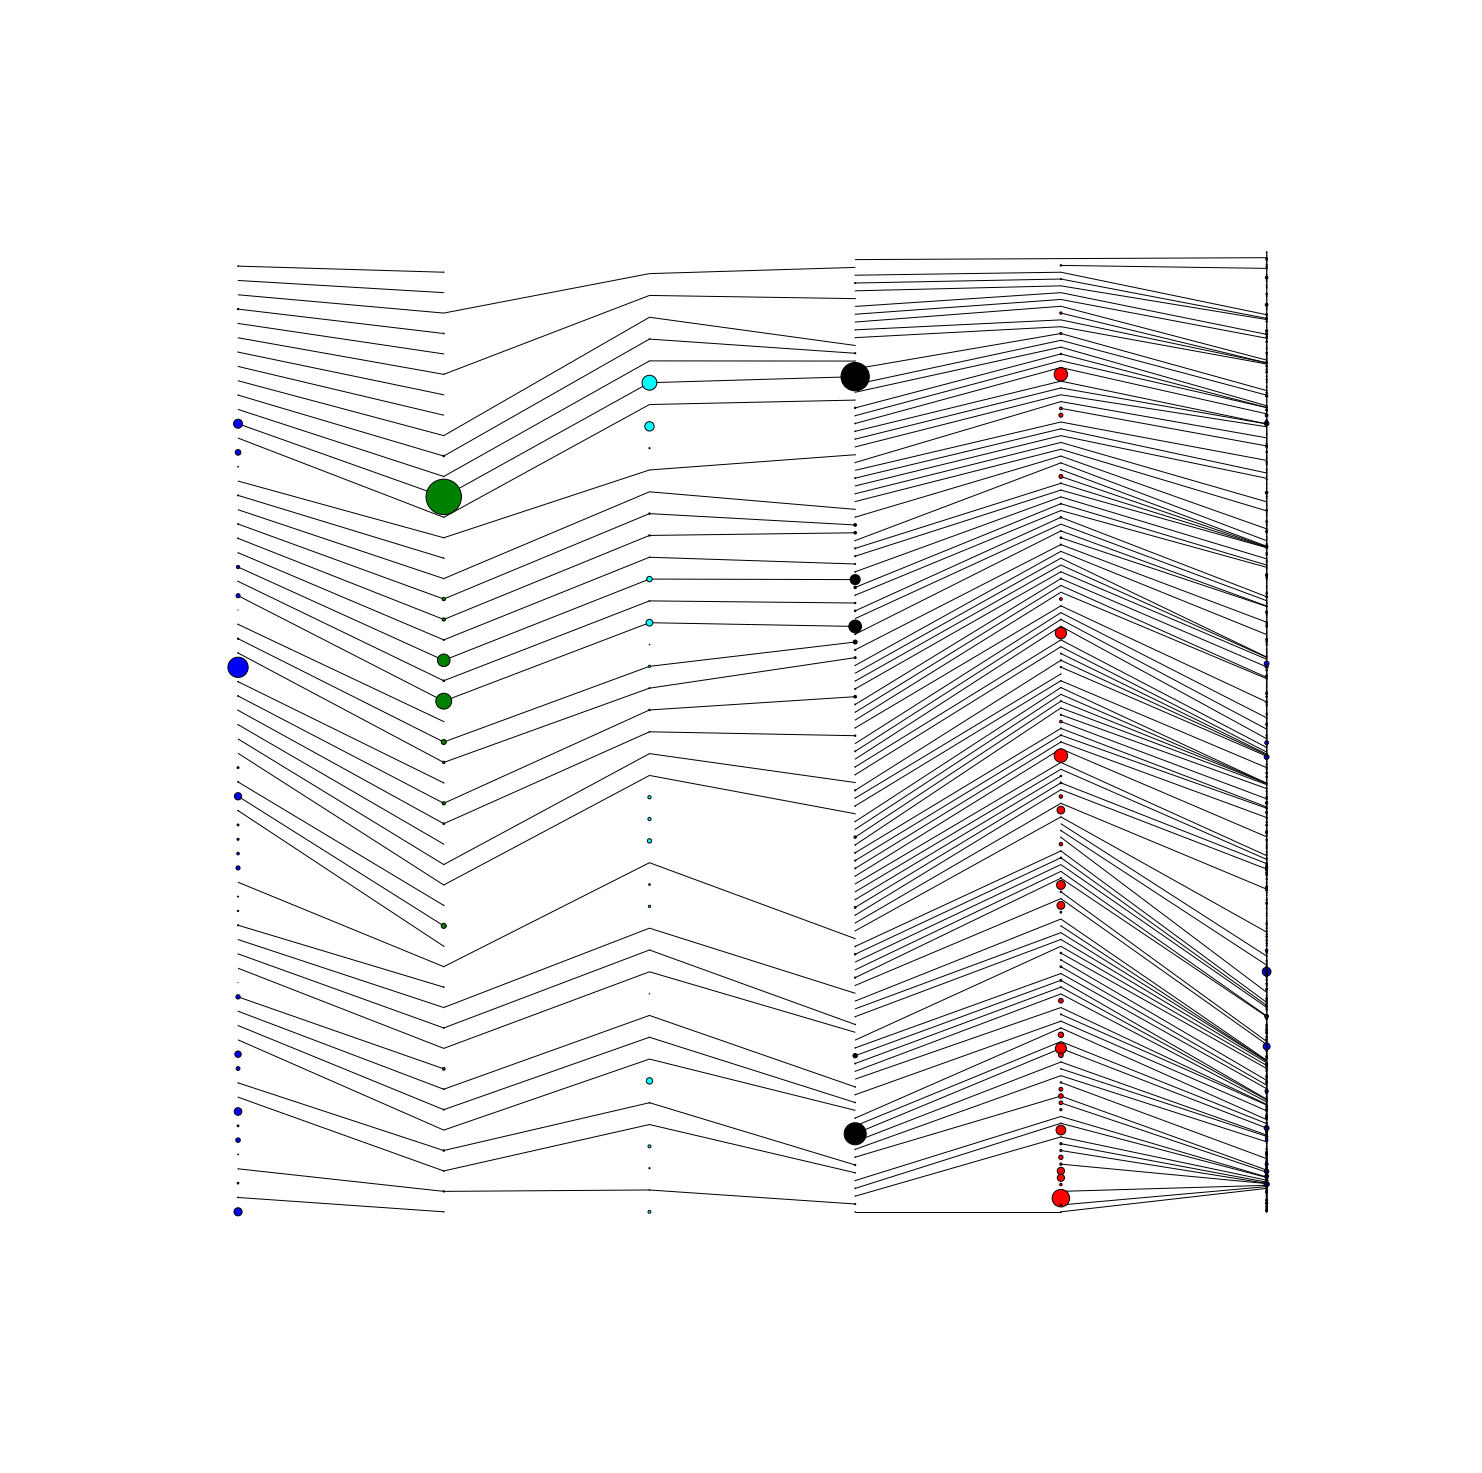

In [11]:
print('Decomposing value chain...')
propaan_sup = get_fragment(rel_nodes,'Vloeib.PropaanButaan','supply')
propaan_suppliers = [str(e)+' supply Vloeib.PropaanButaan' for e in propaan_sup['BEID'].tolist()]
propaan_use = get_fragment(rel_nodes,'Vloeib.PropaanButaan','use')
propaan_users = [str(e)+' use Vloeib.PropaanButaan' for e in propaan_use['BEID'].tolist()]

propyleen_sup = get_fragment(rel_nodes,'Propyleen','supply')
propyleen_suppliers = [str(e)+' supply Propyleen' for e in propyleen_sup['BEID'].tolist()]
propyleen_use = get_fragment(rel_nodes,'Propyleen','use')
propyleen_users = [str(e)+' use Propyleen' for e in propyleen_use['BEID'].tolist()]

polypropyleen_sup = get_fragment(rel_nodes,'Polypropyleen','supply')
polypropyleen_suppliers = [str(e)+' supply Polypropyleen' for e in polypropyleen_sup['BEID'].tolist()]
polypropyleen_use = get_fragment(rel_nodes,'Polypropyleen','use')
polypropyleen_users = [str(e)+' use Polypropyleen' for e in polypropyleen_use['BEID'].tolist()]

verpakking_sup = get_fragment(rel_nodes,'Verpakking.kunst.','supply')
verpakking_suppliers = [str(e)+' supply Verpakking.kunst.' for e in verpakking_sup['BEID'].tolist()]
verpakking_use = get_fragment(rel_nodes,'Verpakking.kunst.','use')
verpakking_users = [str(e)+' use Verpakking.kunst.' for e in verpakking_use['BEID'].tolist()]

print('Decomposed value chain ready\n')
print('Adding nodes...')

BG = nx.Graph()
nodes = BG.nodes()

# add nodes here
BG.add_nodes_from(propaan_suppliers  , bipartite=0) # Add the node attribute "bipartite"
BG.add_nodes_from(propaan_users      , bipartite=1)
BG.add_nodes_from(propyleen_suppliers, bipartite=2)
BG.add_nodes_from(propyleen_users    , bipartite=3)
BG.add_nodes_from(polypropyleen_suppliers, bipartite=4)
BG.add_nodes_from(polypropyleen_users    , bipartite=5)
# BG.add_nodes_from(verpakking_suppliers, bipartite=6)
# BG.add_nodes_from(verpakking_users    , bipartite=7)

print('All nodes added\n')

# for each of the parts create a set 
nodes_0 = {n for n, d in BG.nodes(data=True) if d['bipartite']==0}
nodes_1 = {n for n, d in BG.nodes(data=True) if d['bipartite']==1}
nodes_2 = {n for n, d in BG.nodes(data=True) if d['bipartite']==2}
nodes_3 = {n for n, d in BG.nodes(data=True) if d['bipartite']==3}
nodes_4 = {n for n, d in BG.nodes(data=True) if d['bipartite']==4}
nodes_5 = {n for n, d in BG.nodes(data=True) if d['bipartite']==5}
# nodes_6 = {n for n, d in BG.nodes(data=True) if d['bipartite']==6}
# nodes_7 = {n for n, d in BG.nodes(data=True) if d['bipartite']==7}

# set the location of the nodes for each set
pos = dict()

print('Updating locations of nodes...')
pos.update( (n, (0,i*200/len(nodes_0))) for i, n in enumerate(sorted(nodes_0)) )
pos.update( (n, (1,i*200/len(nodes_1))) for i, n in enumerate(sorted(nodes_1)) )
pos.update( (n, (2,i*200/len(nodes_2))) for i, n in enumerate(sorted(nodes_2)) )
pos.update( (n, (3,i*200/len(nodes_3))) for i, n in enumerate(sorted(nodes_3)) )
pos.update( (n, (4,i*200/len(nodes_4))) for i, n in enumerate(sorted(nodes_4)) )
pos.update( (n, (5,i*200/len(nodes_5))) for i, n in enumerate(sorted(nodes_5)) )
# pos.update( (n, (6,i*200/len(nodes_6))) for i, n in enumerate(sorted(nodes_6)) )
# pos.update( (n, (i*200/len(nodes_7),7)) for i, n in enumerate(sorted(nodes_7)) )
# add edges here

print('Locations of nodes updated\n')
print('Adding links...')

for BEID_sup in nodes_0:
    for BEID_use in nodes_1:
        if BEID_sup[0:8] == BEID_use[0:8]:
            BG.add_edges_from([(BEID_sup,BEID_use)])
print('Added links of layer 0')

for BEID_sup in nodes_1:
    for BEID_use in nodes_2:
        if BEID_sup[0:8] == BEID_use[0:8]:
            BG.add_edges_from([(BEID_sup,BEID_use)])
print('Added links of layer 1')            

for BEID_sup in nodes_2:
    for BEID_use in nodes_3:
        if BEID_sup[0:8] == BEID_use[0:8]:
            BG.add_edges_from([(BEID_sup,BEID_use)])
print('Added links of layer 2')

for BEID_sup in nodes_3:
    for BEID_use in nodes_4:
        if BEID_sup[0:8] == BEID_use[0:8]:
            BG.add_edges_from([(BEID_sup,BEID_use)])
print('Added links of layer 3')

for BEID_sup in nodes_4:
    for BEID_use in nodes_5:
        if BEID_sup[0:8] == BEID_use[0:8]:
            BG.add_edges_from([(BEID_sup,BEID_use)])
print('Added links of layer 4')
print('Added all links\n')
            
print('Updating node sizes...')
node_sizes = []
for node in BG.nodes():
    node_sizes.append(float(get_volume(rel_nodes,node))*20)
print('Updated node sizes\n')

    
# colors per layer
color_map=[]
for node in BG:
    if node in nodes_0:
        # propaan producers
        color_map.append("blue")
    elif node in nodes_1:
        # propaan consumers
        color_map.append("green")
    elif node in nodes_2:
        # propyleen producers
        color_map.append("cyan")
    elif node in nodes_3:
        # propyleen consumers
        color_map.append("black")
    elif node in nodes_4:
        # polypropyleen producers
        color_map.append("red")
    elif node in nodes_5:
        # polypropyleen consumers
        color_map.append("blue")
#     elif node in nodes_6:
#         color_map.append("green")
        
print('Updated node colors\n')        

plt.figure(3,figsize=(20,20))
nx.draw(BG, pos=pos,node_size=node_sizes,node_color=color_map)

#### Node removal

In [200]:
import random
import statistics as stat

def calculate_loss(df,n_removed_nodes):
    producers = df['BEID'].values.tolist()
    removed_producers = []
    for i in range(0,n_removed_nodes):
        targeted_node = random.choice(producers)
        removed_producers.append(targeted_node)
        producers.remove(targeted_node)
    failed_producers = df[df['BEID'].isin(removed_producers)]
    failed_production = failed_producers['volume'].sum()
    remaining_nodes = df[df['BEID'].isin(producers)]
    maximum_compensation = remaining_nodes['volume'].sum()*.2
    if maximum_compensation > failed_production:
        return 0
    loss_production = failed_production - maximum_compensation
    return loss_production

def calculate_loss_simulation(df,iterations,n_removed_nodes):
    results = []
    for iteration in range(0,iterations):
        loss_production = calculate_loss(df,n_removed_nodes)
        results.append(int(loss_production))
    return [stat.mean(results),stat.stdev(results)]

def full_simulation(df,iterations):
    results = []
    max_nodes = df.shape[0]
    for n_removed_nodes in range (0,max_nodes):
        results.append(calculate_loss_simulation(df,iterations,n_removed_nodes))
    return results

def visualize_loss(results):
    x_axis = np.linspace(1,len(results),len(results))
    means = [item[0] for item in results]
    stdevs = [item[1] for item in results]
    fig, ax = plt.subplots()
    plt.errorbar(x_axis, means, stdevs, linestyle='None', marker='^')
    plt.show()
#     plt.errorbar(x_axis,means, stdevs, fmt='o', color='black')

67


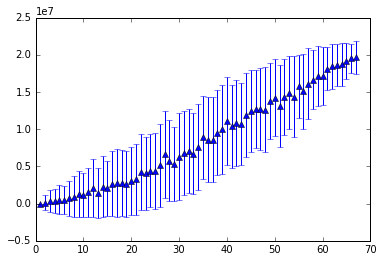

In [202]:
visualize_loss(full_simulation(prop_producers,100))

In [203]:
propaan_producers = get_fragment(rel_nodes,'Vloeib.PropaanButaan','supply')
propyleen_producers = get_fragment(rel_nodes,'Propyleen','supply')
polypropyleen_producers = get_fragment(rel_nodes,'Polypropyleen','supply')

67


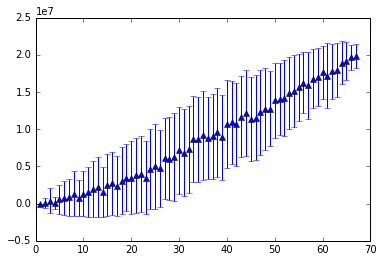

In [204]:
visualize_loss(full_simulation(propaan_producers,100))

44


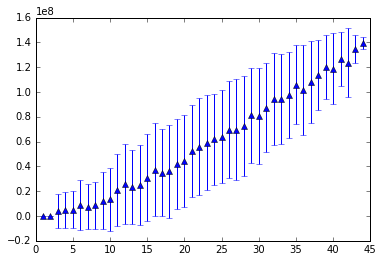

In [205]:
visualize_loss(full_simulation(propyleen_producers,100))

141


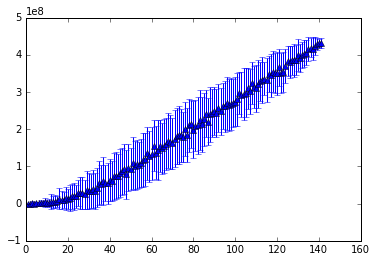

In [206]:
visualize_loss(full_simulation(polypropyleen_producers,100))